In [1]:
#importeren van alle benodigde libraries en functies
import os,re,glob,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import VoigtModel
import pywt
%run scripts_dataverwerking.ipynb

In [91]:
#benoemen van alle variabelen

path       = '.\\calibratie v2\-a_3C 1'   #Het pad naar het mapje met de data.

data_begin = 0                   #Begin positie van de data. begint bij 0.
data_eind  = 5                   #Eind positie van de data.
xMin_raw   = 2000                #Het minimale range van de ruwe data.
xMax_raw   = 8500                #Het maximale range van de ruwe data.
xMin_ruis  = 270                 #Het minimale range van de gefilterde data. 
xMax_ruis  = 370                 #Het maximale range van de gefilterde data. 
#De absorptie piek moet binnen deze range vallen, dit kan gecheckt worden met de onderste cell.
gekalibreerd='JA'                #Is de TDLAS gekalibreerd (JA/NEE)
rc=0.0025935021898186            #Richtingscoeficent van de fit, als de kalibratie nog niet is uitgevoerd dan: rc = 0 

File found: .\calibratie v2\-a_3C 1\30042024_3C_1.txt
oppervlakte onder de voigt profile is 18.960063784982445 en heeft een concentratie van 7310.602574161924 µmol/mol
File found: .\calibratie v2\-a_3C 1\30042024_3C_2.txt
oppervlakte onder de voigt profile is 19.065375210005406 en heeft een concentratie van 7351.208448888533 µmol/mol
File found: .\calibratie v2\-a_3C 1\30042024_3C_3.txt
oppervlakte onder de voigt profile is 19.0576940652755 en heeft een concentratie van 7348.246760727998 µmol/mol
File found: .\calibratie v2\-a_3C 1\30042024_3C_4.txt
oppervlakte onder de voigt profile is 19.113076887085175 en heeft een concentratie van 7369.60121418753 µmol/mol
File found: .\calibratie v2\-a_3C 1\30042024_3C_5.txt
oppervlakte onder de voigt profile is 19.15025866871905 en heeft een concentratie van 7383.937728642711 µmol/mol


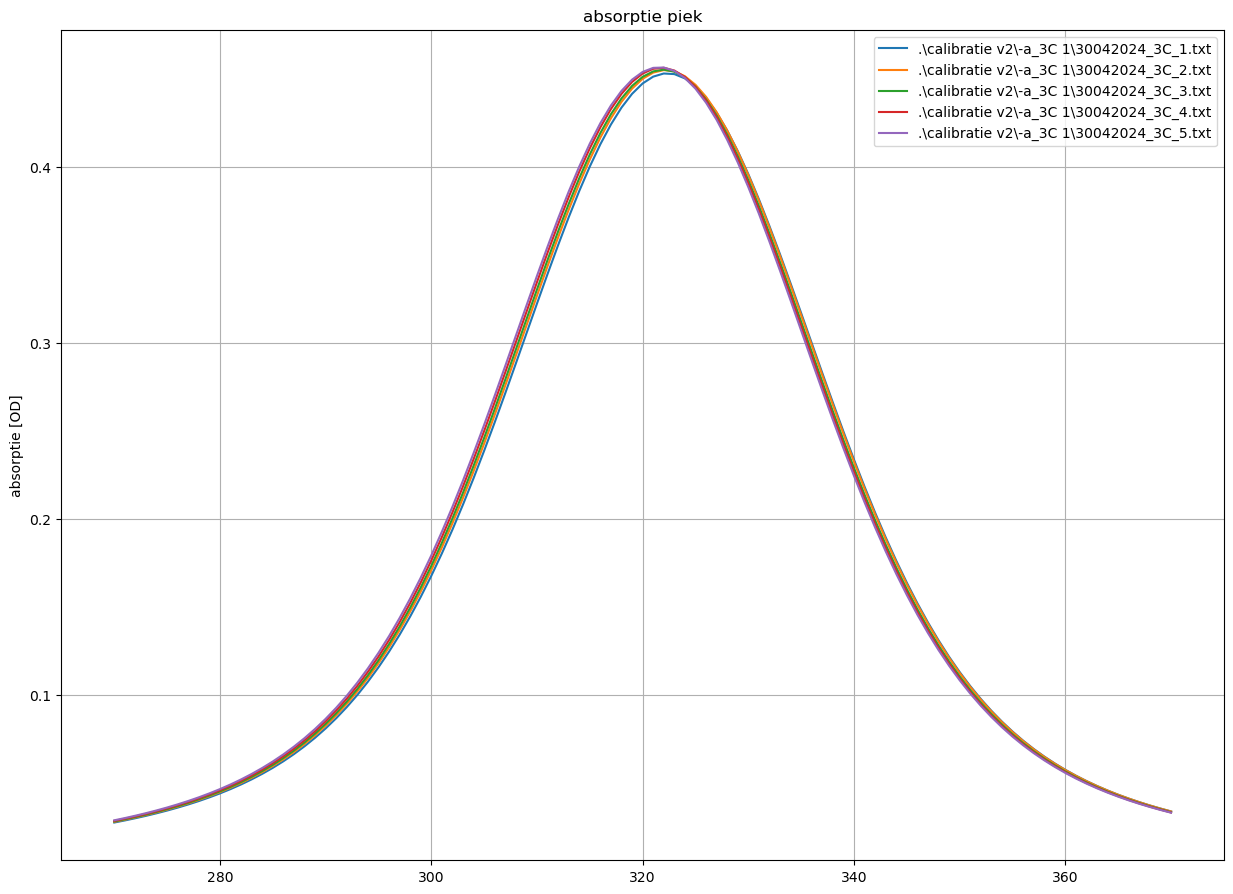

In [98]:
fig , ax= plt.subplots(figsize=(15,11), dpi=100) 
fnL  = glob.glob(path+'/*')
lengte_data = (xMax_raw-xMin_raw)/10
#for-loop zodat elk bestand in één keer geplot wordt 
for fn in fnL[data_begin:data_eind]:
    raw = loadTDLAS(*os.path.split(fn))
    raw = limitData(raw, xMin_raw, xMax_raw)
    #wavelet ruis vermindering   
    FPData = np.array(raw.absorption.values).reshape(int(lengte_data),-1)
    DWTcoeffs = pywt.wavedec(FPData[:,1], 'db4')
    DWTcoeffs[-1] = np.zeros_like(DWTcoeffs[-1])
    DWTcoeffs[-2] = np.zeros_like(DWTcoeffs[-2])
    DWTcoeffs[-3] = np.zeros_like(DWTcoeffs[-3])
    DWTcoeffs[-4] = np.zeros_like(DWTcoeffs[-4])

    #DWTcoeffs[-5] = np.zeros_like(DWTcoeffs[-5])
    #DWTcoeffs[-6] = np.zeros_like(DWTcoeffs[-6])
    #DWTcoeffs[-7] = np.zeros_like(DWTcoeffs[-7])


    filtered_data_dwt=pywt.waverec(DWTcoeffs,'db4',mode='symmetric',axis=-1)
    
    
    #voeg het gefiltered Wavelet data samen met de originele dataframe
    data = np.vstack((np.arange(filtered_data_dwt.size),filtered_data_dwt)).T
    wave = pd.DataFrame(data,columns = ['wavelength', 'absorption'])
    
    def limitData(D, xMin=0., xMax=1):
        minInd = D.wavelength.searchsorted(xMin)
        maxInd = D.wavelength.searchsorted(xMax)
    
        A = pd.DataFrame(D.loc[minInd:maxInd])
        A.reset_index(drop=True, inplace=True)
        return A
    
    wave = limitData(wave, xMin_ruis, xMax_ruis)
    #voigt line shape toevoegen
    x = wave.wavelength
    y = wave.absorption
    mod = VoigtModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)
   
    final = y + out.residual
    opp = np.trapz(final)
    if gekalibreerd == 'JA':
        ppm = opp / rc
        print("oppervlakte onder de voigt profile is",opp,'en heeft een concentratie van',ppm,'µmol/mol')
    elif gekalibreerd == 'NEE':
        print("oppervlakte onder de voigt profile is",opp) 
    plt.plot(x, final,label=fn) 
ax.set_title('absorptie piek')

plt.grid()
ax.set_xlabel('')
ax.set_ylabel('absorptie [OD]')  
plt.legend()    
plt.show()

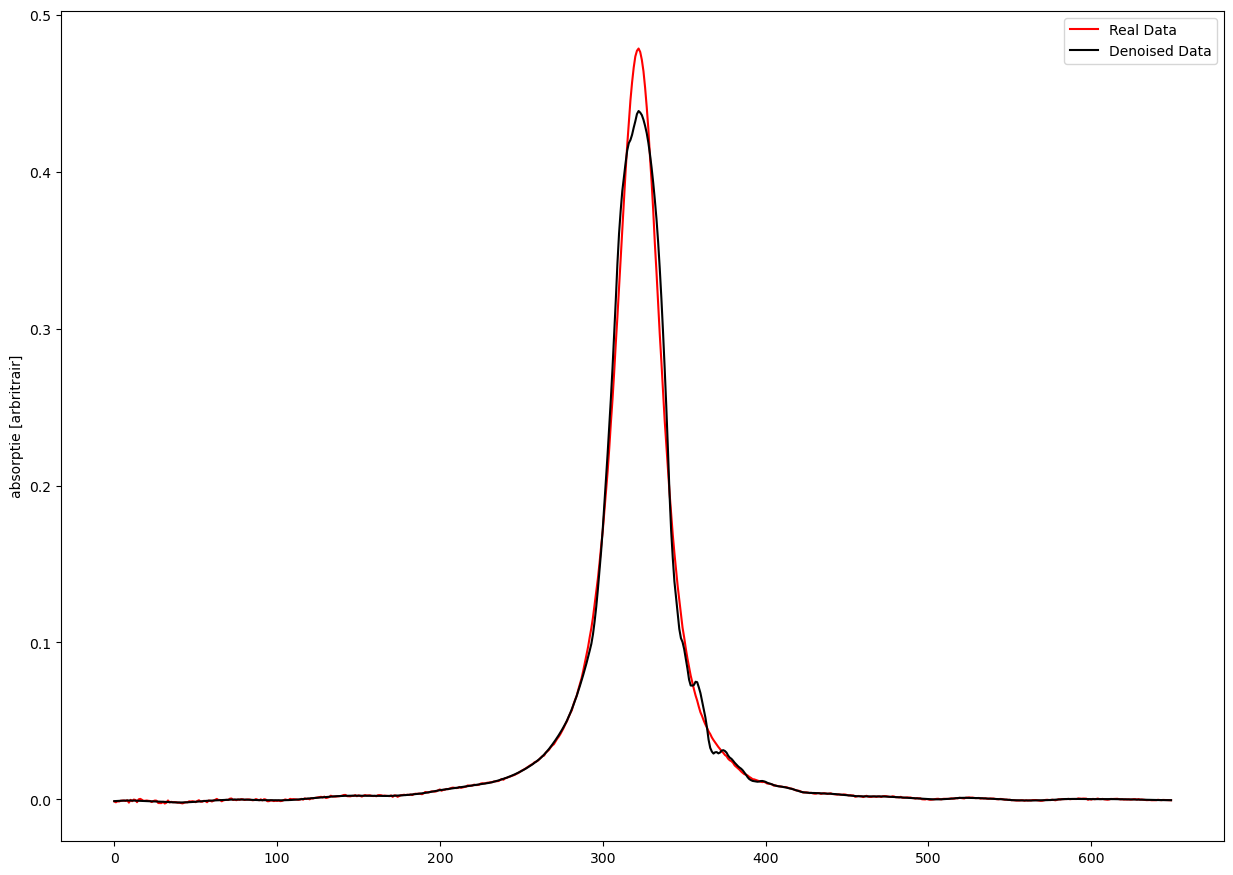

In [107]:
#check voor absorptie piek
FPData = np.array(raw.absorption.values).reshape(650,-1)
DWTcoeffs = pywt.wavedec(FPData[:,1], 'db4')
DWTcoeffs[-1] = np.zeros_like(DWTcoeffs[-1])
DWTcoeffs[-2] = np.zeros_like(DWTcoeffs[-2])
DWTcoeffs[-3] = np.zeros_like(DWTcoeffs[-3])
DWTcoeffs[-4] = np.zeros_like(DWTcoeffs[-4])

#DWTcoeffs[-5] = np.zeros_like(DWTcoeffs[-5])
#DWTcoeffs[-6] = np.zeros_like(DWTcoeffs[-6])
#DWTcoeffs[-7] = np.zeros_like(DWTcoeffs[-7])


filtered_data_dwt=pywt.waverec(DWTcoeffs,'db4',mode='symmetric',axis=-1)
fig , ax= plt.subplots(figsize=(15,11), dpi=100) 
plt.plot(FPData[:,1],color='red')
plt.plot(filtered_data_dwt, markerfacecolor='none',color='black')
#plt.xlim(500,700)
#plt.ylim(-0.002,0.002)
ax.set_xlabel('')
ax.set_ylabel('absorptie [arbritrair]')  
plt.legend(['Real Data', 'Denoised Data'], loc='best')
plt.show()